In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from model_input import input_pipeline

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def plot(imgs, title=None):
    # make sure input is a list
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    plt.figure()
        
    for i in range(len(imgs)):
        if(title is not None): 
            plt.suptitle(title)
        plt.subplot(1, len(imgs), i+1)
        plt.axis("off")
        # fix channels for rgb
        if len(imgs[i].shape) > 2:
            plt.imshow(imgs[i][:,:,[2,1,0]])
        else:
            plt.imshow(imgs[i])

# Samples: 16
Sequence lengths: [62 60 62 63 63 88 73 57 63 54 71 71 73 58 63 61]
Sequence labels: [12 19 17  3 16 11  4 19 13 19  4  8 18  9 14  1]
Sequence type: <class 'numpy.ndarray'>
Sequence shape: (16, 88, 80, 80, 3)


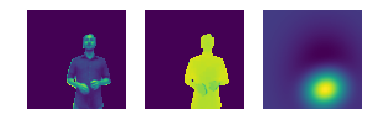

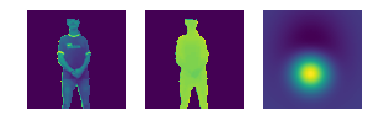

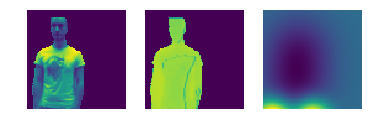

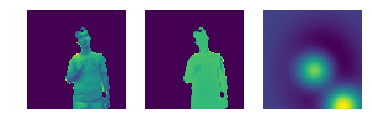

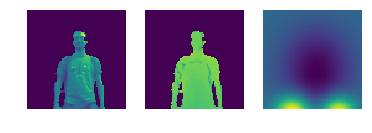

In [3]:
# simple sanity check for input pipeline:

def test_input_loader():
    config = {}
    config['img_height'] = 80
    config['img_width'] = 80
    config['img_num_channels'] = 3
    config['num_epochs'] = 10
    config['lr'] = {}
    config['lr']['batch_size'] = 16
    # Capacity of the queue which contains the samples read by data readers.
    # Make sure that it has enough capacity.
    config['ip_queue_capacity'] = config['lr']['batch_size']*10  
    config['ip_num_read_threads'] = 6
    # Directory of the data.
    config['data_dir'] = "../data/train/"
    # File naming
    config['file_format'] = "dataTrain_%d.tfrecords"
    # File IDs to be used
    config['file_ids'] = list(range(1,10))
    
    # Create a list of TFRecord input files.
    filenames = [os.path.join(config['data_dir'], config['file_format'] % i) for i in config['file_ids']]

    # Create data loading operators. This will be represented as a node in the computational graph.
    batch_samples_op, batch_labels_op, batch_seq_len_op = input_pipeline(filenames, config)

    # Create tensorflow session and initialize the variables (if any).
    sess = tf.Session()
    init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
    sess.run(init_op)
    # Create threads to prefetch the data.
    # https://www.tensorflow.org/programmers_guide/reading_data#creating_threads_to_prefetch_using_queuerunner_objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    batch_samples, batch_labels, batch_seq_len = sess.run([batch_samples_op, batch_labels_op, batch_seq_len_op])
    
    # Print 
    print("# Samples: " + str(len(batch_samples)))
    print("Sequence lengths: " + str(batch_seq_len))
    print("Sequence labels: " + str(batch_labels))
    
    # Note that the second dimension will give maximum-length in the batch, i.e., the padded sequence length.
    print("Sequence type: " + str(type(batch_samples)))
    print("Sequence shape: " + str(batch_samples.shape))

    # plot some
    for i in range(5):
        sample = batch_samples[i][0]
        rgb = sample[...,0].squeeze()
        dep = sample[...,1].squeeze()
        bod = sample[...,2].squeeze()
        plot([rgb,dep,bod])
    
test_input_loader()

In [ ]:
x = np.linspace(0,79,80)
print(x)
y = np.linspace(0,80,81)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

# print(pos)

mu_x = 40
variance_x = 30

mu_y = 40
variance_y = 150

rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

mu_x2 = 40
variance_x2 = 300

mu_y2 = 40
variance_y2 = 150

rv2 = multivariate_normal([mu_x2, mu_y2], [[variance_x2, 0], [0, variance_y2]])

surface = rv.pdf(pos)-rv2.pdf(pos)

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y,surface,cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

print(surface.max())
print(surface.min())
print(surface.std())
print(surface.mean())


